# Hydrological Simulation Workflow

This notebook demonstrates how to run hydrological simulations using the prediction workflow from the hydroml package.

The hydroml package contains several workflow modules that provide wrapper functions for different tasks. Here we focus on the prediction workflow, which allows us to:

1. Load a trained model
2. Provide input data (dynamic and static features)
3. Generate streamflow predictions

The key function we'll use is `run_hydrological_simulation()` which handles the entire prediction pipeline.

In [1]:
# imports
%load_ext autoreload 
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from hydroml.utils import helpers as h
from hydroml.workflow.prediction import run_hydrological_simulation


# Loading Sample Data

In this example, we will use the following:  

1. **A Pre-trained Model**: The model is loaded from a specified file path.  
2. **Sample Dynamic Data**: This includes time-series data of precipitation and evapotranspiration for catchment 401208. The dynamic data for this pre-trained model are derived from AWAP (currently referred to as AGCD) and evapotranspiration (ET) data using the Morton wet method from SILO. As the model was trained using this specific dataset, ensure that your forcing data originates from the same source or is free from bias when compared to these datasets.  
3. **Static Catchment Attributes**: This includes properties such as catchment area, slope, etc., for the same catchment.

The sample data is provided in CSV and JSON formats, located in the `sample_data` directory.


To run a simulation using hydroml, a directory with the following files is required:
 1. last.ckpt - The trained model weights and parameters
 2. config.yaml - Model configuration including architecture and training settings
 3. params.yaml - Parameters for transforming/normalizing dynamic input data

In [2]:
model_path = Path('../sample_data/model/version_0')
list(model_path.glob('*'))

[WindowsPath('../sample_data/model/version_0/config.yaml'),
 WindowsPath('../sample_data/model/version_0/finetune_all'),
 WindowsPath('../sample_data/model/version_0/finetune_head_dynamic_embedding'),
 WindowsPath('../sample_data/model/version_0/last.ckpt'),
 WindowsPath('../sample_data/model/version_0/params.yaml')]

In [3]:
# insppect config
from hydroml.config.config import load_config

config = load_config(model_path/'config.yaml')


print(f"calibration period is: {config.cal['periods']}")
print(f"valibration period is: {config.val['periods']}")

# Please note that the CAMELS-AUS dataset only covers the period from 1975 to 2014, 
# so any periods outside this range will automatically be discarded.

calibration period is: [['1970-01-01', '2005-01-01']]
valibration period is: [['2005-01-01', '2015-01-01']]


Then we need to load the sample data set:

In [4]:
catchment_id = '401208'
dynamic_data=pd.read_csv(f'../sample_data/{catchment_id}.csv', index_col=0, parse_dates=True)
static_data=h.read_json(f'../sample_data/{catchment_id}_attributes.json')

# Running the Simulation

Now that we have loaded our data and model, we can run the hydrological simulation. The `run_hydrological_simulation()` function takes:

- The path to the trained model
- Dynamic input data (precipitation and evapotranspiration time series)  
- Static catchment attributes
- Catchment ID
- Additional parameters like device specification

The function returns an xarray Dataset containing the simulation results, including both predictions and observed values (if available).

Note: As the model might be calibrated on another system with gpu, we need to specify the device to run the simulation on cpu.

In [5]:
# Run the simulation
simulation = run_hydrological_simulation(model_path,
                                        dynamic_data,
                                        static_data,
                                        catchment_id,
                                        device='cpu') 

Transforming data: loading transform parameters from ..\sample_data\model\version_0\params.yaml


l:\work\sho108_handover\hydroml\.venv\Lib\site-packages\torch\utils\data\dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 10 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Visualizing the Results
#
Now we'll visualize the simulation results in two ways:
1. A plot of the full simulation period to see the overall performance
2. A detailed view of a single year (2000) to better examine the model's ability to capture seasonal patterns

We'll also calculate some key performance metrics like NSE (Nash-Sutcliffe Efficiency) and KGE (Kling-Gupta Efficiency) 
to quantitatively evaluate the model's performance.


<Figure size 1200x300 with 0 Axes>

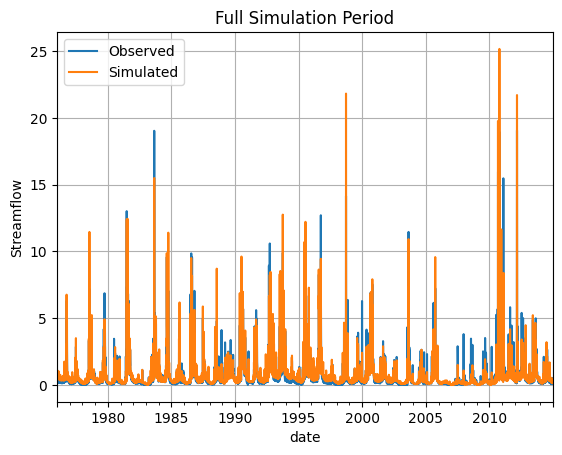

<Figure size 1200x300 with 0 Axes>

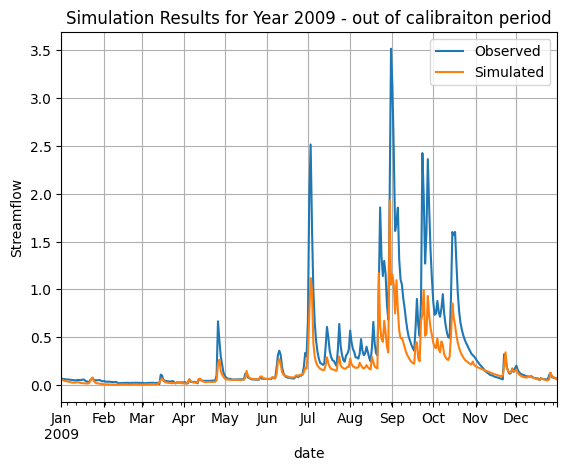

<Figure size 1200x300 with 0 Axes>

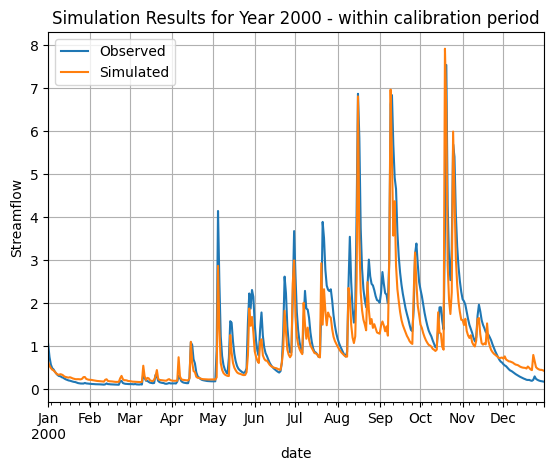

In [6]:
# Convert simulation results to a pandas DataFrame for easier plotting
df = (simulation
      .sel(catchment_id=catchment_id)  # Select the specific catchment
      .to_dataframe()
      .reset_index()
      .set_index('date')
      .drop(columns=['catchment_id', 'lead_time', 'feature']))

# Rename columns to be more descriptive
df.columns = ['observed', 'simulated'] 

# Plot the full simulation period
plt.figure(figsize=(12, 3))
df.plot()
plt.title('Full Simulation Period')
plt.ylabel('Streamflow')
plt.legend(['Observed', 'Simulated'])
plt.grid(True)

# Plot a single year (2009) to see more detail
plt.figure(figsize=(12, 3))
df.loc[df.index.year == 2009].plot()
plt.title('Simulation Results for Year 2009 - out of calibraiton period')
plt.ylabel('Streamflow')
plt.legend(['Observed', 'Simulated'])
plt.grid(True)


# Plot a single year (2000) to see more detail
plt.figure(figsize=(12, 3))
df.loc[df.index.year == 2000].plot()
plt.title('Simulation Results for Year 2000 - within calibration period')
plt.ylabel('Streamflow')
plt.legend(['Observed', 'Simulated'])
plt.grid(True)



# Performance Metrics

## Performance Metrics Explanation

To evaluate the performance of our hydrological simulation, we will use several key metrics:

1. **Nash-Sutcliffe Efficiency (NSE)**:
   - The NSE is a normalized statistic that determines the relative magnitude of the residual variance compared to the measured variance. It ranges from -∞ to 1, where:
     - **1** indicates a perfect match between observed and simulated values.
     - **0** indicates that the model predictions are as accurate as the mean of the observed data.
     - **Negative values** indicate that the model is performing worse than simply using the mean of the observed data.
   - A higher NSE value signifies better model performance.

2. **Kling-Gupta Efficiency (KGE)**:
   - The KGE is a more comprehensive metric that considers three components: correlation, bias, and variability. It ranges from -∞ to 1, where:
     - **1** indicates a perfect match.
     - **0** indicates no correlation.
     - Negative values indicate poor performance.
   - The KGE is particularly useful because it provides insights into different aspects of model performance, making it a robust choice for hydrological modeling.

3. **Root Mean Square Error (RMSE)**:
   - RMSE measures the average magnitude of the errors between observed and simulated values. It is calculated as the square root of the average of squared differences. Lower RMSE values indicate better model performance, as they reflect smaller discrepancies between observed and predicted values.

4. **Bias**:
   - Bias indicates the average difference between observed and simulated values. A bias close to zero suggests that the model predictions are neither systematically overestimating nor underestimating the observed values. Positive bias indicates overestimation, while negative bias indicates underestimation.

5. **Relative Bias**:
   - This metric expresses bias as a percentage of the observed mean, providing a normalized view of the bias. It helps in understanding the model's performance relative to the scale of the observed data.

6. **Absolute Bias**:
   - Absolute bias is the absolute value of the bias, providing a straightforward measure of the average error without regard to direction.

By analyzing these metrics, we can gain valuable insights into how well our model is performing and identify areas for potential improvement. In the following code block, we will calculate these metrics using the `Metrics` class from the `hydroml.evaluation.metrics` module.

In [7]:
from hydroml.evaluation.metrics import Metrics   
Metrics(simulation['y'], simulation['prediction']).all_metrics().to_dataframe()


,,,nse,kge,rmse,bias,relative_bias,absolute_bias,nse_sqrt
catchment_id,lead_time,feature,,,,,,,
401208,0,0,0.75572,0.799177,0.448323,1.054611,0.054611,1.054611,0.782163
